# TSP Environment Rendering

Here we demonstrate some additional usage of graphenv in visualizing environment solutions

In [1]:
import subprocess
from copy import copy
from itertools import chain
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
from graphenv.examples.tsp.graph_utils import make_complete_planar_graph
from graphenv.examples.tsp.tsp_state import TSPState
from graphenv.graph_env import GraphEnv

%matplotlib inline

In [2]:
N = 50

# Create the TSPState and GraphEnv objects
state = TSPState(lambda: make_complete_planar_graph(N, seed=1))
env = GraphEnv(
    {
        "state": state,
        "max_num_children": N,
    }
)

In [3]:
%%capture

# Reset the environment and initialize the observation, reward, and done fields
obs, info = env.reset()
greedy_reward = 0
done = False

with TemporaryDirectory(dir=".") as tmpdir:
    while not done:

        # Select the action with the minimum distance from the parent node
        action = np.argmin([x["parent_dist"] for x in obs[1:]])

        # Get the observation for the next set of candidate nodes,
        # incremental reward, and done flags
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Append the step's reward to the running total
        greedy_reward += reward

        # Render the intermediate environment and save as an image
        fig, ax = env.render()
        ax.set_title(f"distance = {greedy_reward:.3f}")
        fig.savefig(Path(tmpdir, f"img{len(env.state.tour):01d}.jpg"), dpi=100)

    # Convert the list of frames to a video
    subprocess.run(
        "ffmpeg -i img%01d.jpg -vcodec libx264 -acodec libfaac -y ../movie.mp4",
        shell=True,
        check=True,
        cwd=tmpdir,
        capture_output=True,
    )

    subprocess.run(
        "ffmpeg -i img%01d.jpg -vcodec libvpx -acodec libvorbis -y ../movie.webm",
        shell=True,
        check=True,
        cwd=tmpdir,
        stdout=None,
        capture_output=True,
    )

<video controls>
  <source src="movie.webm" type="video/webm">
  <source src="movie.mp4" type="video/mp4">    
Your browser does not support the video tag.
</video> 

*File Links:*
[movie.webm](movie.webm), [movie.mp4](movie.mp4)

In [4]:
print(f"Total greedy reward: {greedy_reward}")

Total greedy reward: -7.2034767022636865


# Beam Search

GraphEnvs can be copied using python's shallow `copy()` function, which allows parallelizing search strategies. Here we demonstrate this functionality in a simple beam search, where the top K shortest solutions are expanded on each iteration.

In [5]:
def expand(env, previous_reward):
    """Given an environment (and it's cumulative reward), return possible next actions
    and their associated rewards.

    Note, here we avoid calling env.step(), as openai's API would require enumerating
    the full search tree for the child nodes.
    """
    return (
        {
            "action_index": i,
            "reward": previous_reward + child.reward,
            "env": copy(env),  # Here, we copy the environment to maintain seperate tours
        }
        for i, child in enumerate(env.state.children)
    )


def beam_search(env_list, k):
    """Expand the given (env, reward) pairs, and subsample only the top K from the next
    iteration of results.
    """

    top_actions = sorted(
        chain(*(expand(env, previous_reward) for env, previous_reward in env_list)),
        key=lambda x: x["reward"],
        reverse=True,
    )[:k]

    for entry in top_actions:
        obs, reward, terminated, truncated, info = entry["env"].step(entry["action_index"])

    return [(entry["env"], entry["reward"]) for entry in top_actions], done

In [6]:
obs, info = env.reset()
env_list = [(env, 0)]
done = False

# A beam search with K=1 should be equivalent to greedy search
while not done:
    env_list, done = beam_search(env_list, 1)

assert np.isclose(env_list[0][1], greedy_reward)

In [7]:
obs, info = env.reset()
env_list = [(env, 0)]
done = False

# Here, we show a beam search with K=50 that beats the greedy baseline
while not done:
    env_list, done = beam_search(env_list, 50)

In [8]:
env_list[:5]

[(<graphenv.graph_env.GraphEnv at 0x15a0ab8b0>, -6.946512200757427),
 (<graphenv.graph_env.GraphEnv at 0x15aba0280>, -7.01145372119443),
 (<graphenv.graph_env.GraphEnv at 0x15aba0340>, -7.0149204046663485),
 (<graphenv.graph_env.GraphEnv at 0x15aba5d30>, -7.050288524545745),
 (<graphenv.graph_env.GraphEnv at 0x15aba5bb0>, -7.0804851031169225)]

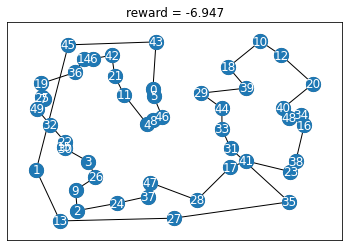

In [9]:
fig, ax = env_list[0][0].render()
_ = ax.set_title(f"reward = {env_list[0][1]:.3f}")